In [1]:
# Import required libraries
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu126
CUDA available: True


## 1. Define Hyperparameters

In [9]:
# Hyperparameters
n_epochs = 50
batch_size = 128
lr = 0.0002
latent_dim = 100
save_interval = 500
img_size = 28

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load MNIST Dataset

In [3]:
# Create data directory
os.makedirs('./data', exist_ok=True)
os.makedirs('./images', exist_ok=True)
os.makedirs('./models', exist_ok=True)

# Load MNIST dataset
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ])),
    batch_size=batch_size, shuffle=True, drop_last=True
)

print(f"Dataset loaded successfully!")
print(f"Number of batches: {len(dataloader)}")
print(f"Total training samples: {len(dataloader.dataset)}")

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.24MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 151kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 848kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Dataset loaded successfully!
Number of batches: 937
Total training samples: 60000


## 3. Visualize Sample Real Images

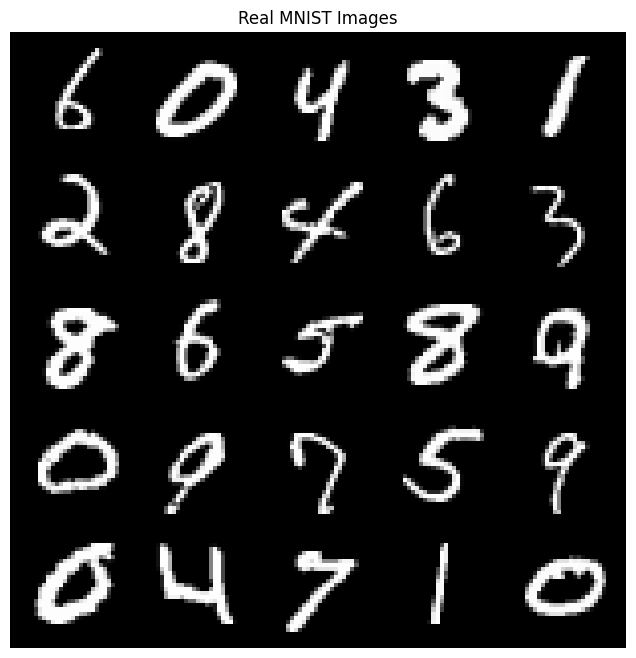

In [4]:
# Get a batch of real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real MNIST Images")
plt.imshow(np.transpose(make_grid(real_batch[0][:25], nrow=5, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## 4. Define Generator Network

The Generator takes random noise (latent vector) and generates fake images.

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, base_channel):
        super(Generator, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.base_channel = base_channel
        
        # Transposed convolutions to upsample from latent space to image
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(in_channels, base_channel * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_channel * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 8, base_channel * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 4, base_channel * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.ConvTranspose2d(base_channel * 2, base_channel, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, base_channel, 3, 1, 0, dilation=2, bias=False),
            nn.BatchNorm2d(base_channel),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel, out_channels, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.conv_blocks(z)

# Initialize generator
generator = Generator(latent_dim, 1, 128).to(device)
print(f"Generator architecture:")
print(generator)

Generator architecture:
Generator(
  (conv_blocks): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.

## 5. Define Discriminator Network

The Discriminator classifies images as real or fake.

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, base_channel):
        super(Discriminator, self).__init__()
        
        self.in_channels = in_channels
        self.base_channel = base_channel
        
        # Convolutions to downsample image to single classification score
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, base_channel * 1, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel * 1, base_channel * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel * 2, base_channel * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channel * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel * 4, base_channel * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(base_channel * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            nn.Conv2d(base_channel * 8, 1, 1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        return self.model(img).squeeze()

# Initialize discriminator
discriminator = Discriminator(1, 128).to(device)
print(f"Discriminator architecture:")
print(discriminator)

Discriminator architecture:
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(102

## 6. Setup Loss Function and Optimizers

In [7]:
# Binary Cross Entropy Loss
criterion = nn.BCELoss()

# Optimizers for both networks
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

print("Loss function and optimizers initialized!")

Loss function and optimizers initialized!


## 7. Training Loop

The training alternates between:
1. Training the Discriminator to distinguish real from fake images
2. Training the Generator to fool the Discriminator

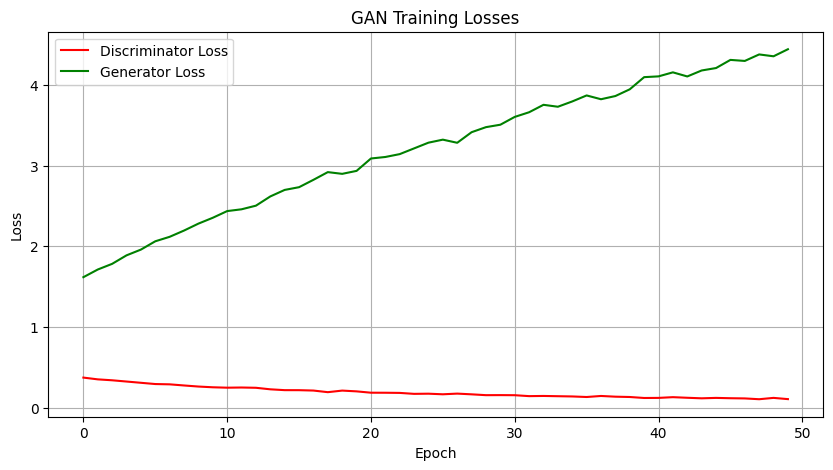

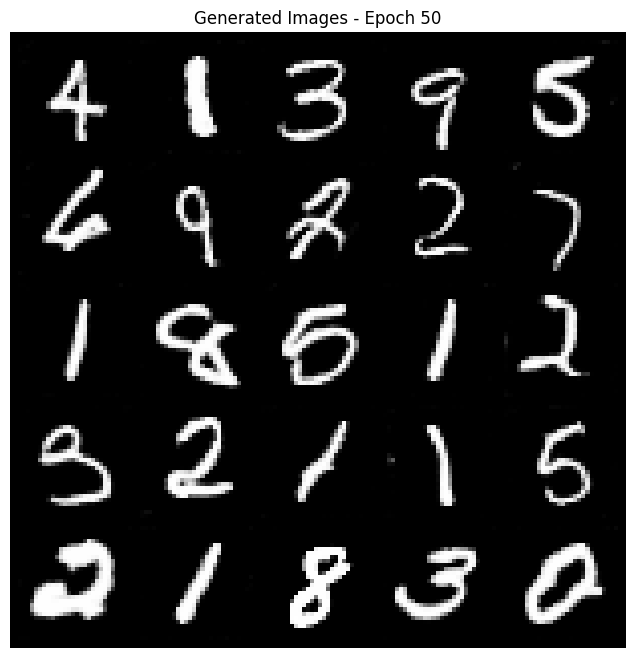

--------------------------------------------------------------------------------
Training Complete!


In [12]:
# Lists to store losses for plotting
G_losses = []
D_losses = []
epoch_list = []

# Fixed noise for consistent visualization
fixed_noise = torch.randn(25, latent_dim, 1, 1).to(device)

print("Starting Training...")
print("-" * 80)

for epoch in range(n_epochs):
    weighted_gen_loss = 0.0
    weighted_dis_loss = 0.0
    
    for i, (imgs, _) in enumerate(dataloader):
        # Get actual batch size (may be different for last batch)
        current_batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Labels for real and fake images (use actual batch size)
        label_0 = torch.zeros(current_batch_size).to(device)
        label_1 = torch.ones(current_batch_size).to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generate fake images
        noise = torch.randn(current_batch_size, latent_dim, 1, 1).to(device)
        fake_image = generator(noise)
        
        # Generator tries to fool discriminator
        prediction_on_fake = discriminator(fake_image)
        gen_loss = criterion(prediction_on_fake, label_1)
        
        gen_loss.backward()
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Loss on real images
        prediction_on_real = discriminator(imgs)
        loss_1 = criterion(prediction_on_real, label_1)
        
        # Loss on fake images (detach to avoid training generator)
        prediction_on_fake = discriminator(fake_image.detach())
        loss_0 = criterion(prediction_on_fake, label_0)
        
        # Total discriminator loss
        d_loss = (loss_0 + loss_1) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # Weighted average losses (following my_gan.py approach)
        weighted_gen_loss = weighted_gen_loss * (i / (i + 1.)) + gen_loss.item() * (1. / (i + 1.))
        weighted_dis_loss = weighted_dis_loss * (i / (i + 1.)) + d_loss.item() * (1. / (i + 1.))
        
        # Save generated images at intervals
        batches_done = epoch * len(dataloader) + i
        if batches_done % save_interval == 0:
            with torch.no_grad():
                fake_sample = generator(fixed_noise)
                save_image(fake_sample, f'./images/epoch_{epoch}_batch_{batches_done}.png', 
                          nrow=5, normalize=True)
            
            # Save models
            torch.save(generator.state_dict(), f'./models/G_epoch_{epoch}_batch_{batches_done}.pth')
            torch.save(discriminator.state_dict(), f'./models/D_epoch_{epoch}_batch_{batches_done}.pth')
    
    # Store epoch losses
    G_losses.append(weighted_gen_loss)
    D_losses.append(weighted_dis_loss)
    epoch_list.append(epoch)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{n_epochs}] | D Loss: {weighted_dis_loss:.4f} | G Loss: {weighted_gen_loss:.4f}")
    
    # Plot losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_list, D_losses, label='Discriminator Loss', color='red')
        plt.plot(epoch_list, G_losses, label='Generator Loss', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('GAN Training Losses')
        plt.grid(True)
        plt.show()
        
        # Show current generated images
        with torch.no_grad():
            fake_sample = generator(fixed_noise)
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title(f"Generated Images - Epoch {epoch+1}")
            plt.imshow(np.transpose(make_grid(fake_sample.cpu(), nrow=5, padding=2, normalize=True), (1, 2, 0)))
            plt.show()

print("-" * 80)
print("Training Complete!")

## 8. Final Loss Curves

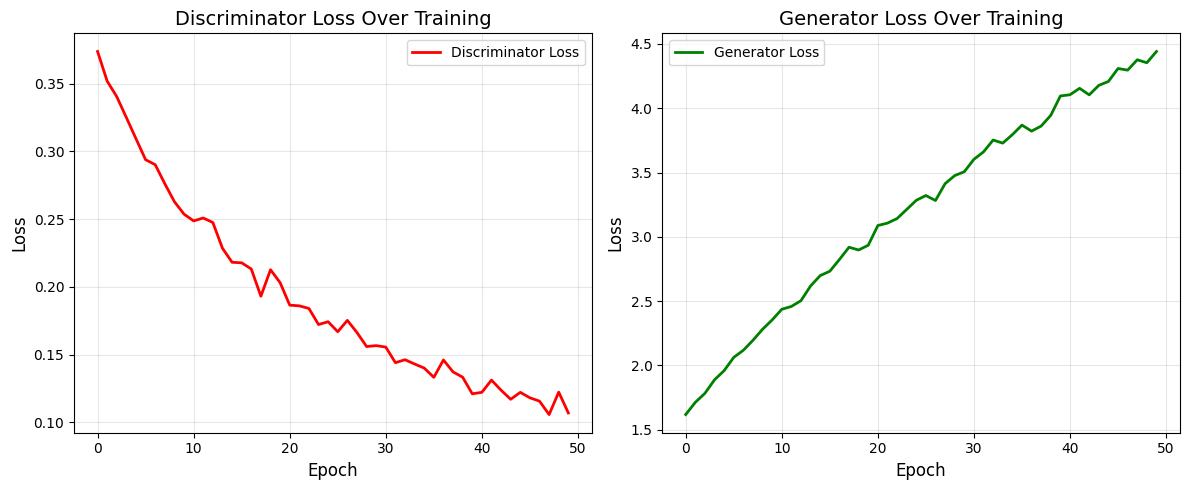

In [13]:
# Plot final loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epoch_list, D_losses, label='Discriminator Loss', color='red', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Discriminator Loss Over Training', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epoch_list, G_losses, label='Generator Loss', color='green', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Generator Loss Over Training', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/training_losses.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save Final Models

In [14]:
# Save the final trained models
torch.save(generator.state_dict(), './models/generator_final.pth')
torch.save(discriminator.state_dict(), './models/discriminator_final.pth')

print("Final models saved successfully!")
print(f"Generator saved to: ./models/generator_final.pth")
print(f"Discriminator saved to: ./models/discriminator_final.pth")

Final models saved successfully!
Generator saved to: ./models/generator_final.pth
Discriminator saved to: ./models/discriminator_final.pth


## 10. Generate Final Sample Images

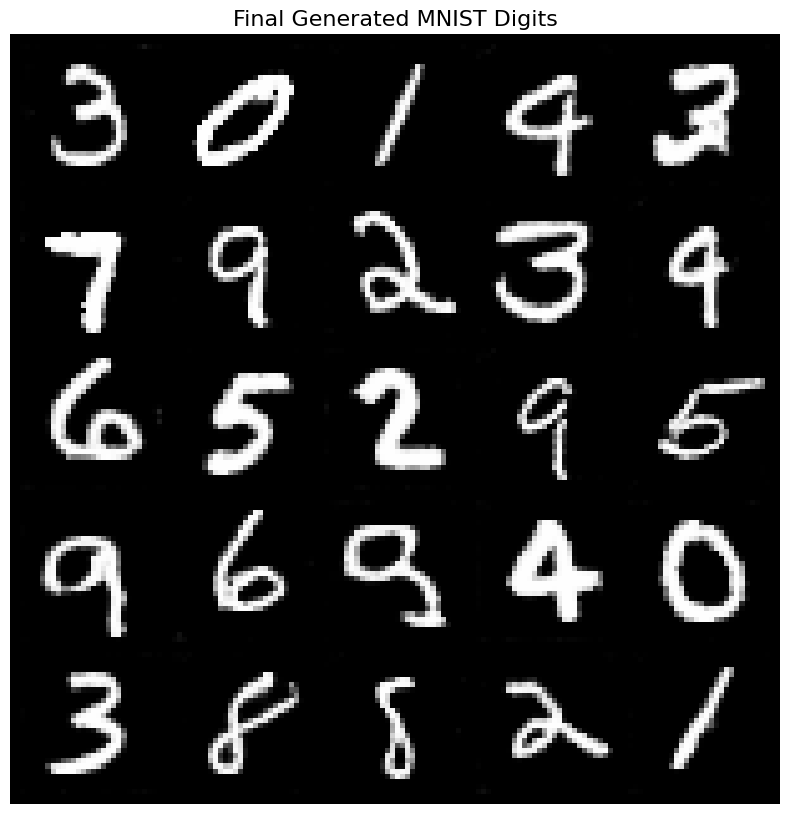


Task 1 Complete!
The GAN has been successfully trained on the MNIST dataset.


In [18]:
# Generate and display final images
generator.eval()
with torch.no_grad():
    sample_noise = torch.randn(25, latent_dim, 1, 1).to(device)
    generated_images = generator(sample_noise)
    
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Final Generated MNIST Digits", fontsize=16)
    plt.imshow(np.transpose(make_grid(generated_images.cpu(), nrow=5, padding=2, normalize=True), (1, 2, 0)))
    plt.savefig('./images/final_generated_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\nTask 1 Complete!")
print("The GAN has been successfully trained on the MNIST dataset.")